# RLbook2020-2.4 Incremental implementation

Several update based on RLbook-2.3-ten-armed-testbed:
* Package smooth() and movingaverage() into utilities.py
* Q update in accordance to 2.4-incremental implementation


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import utilities as util

%load_ext autoreload
%autoreload 2

%matplotlib inline

In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_tes

In [1]:
#print(util.smooth(np.array([1,2,3,4,5,6,7,8,9]),3))
#a = np.array([1,2,3,4,5,6,7,8,9])
#winsize=3
#print(util.movingaverage1(a,winsize))

In [10]:
def k_armed_bandit_one_run(qstar,epsilon,nStep):
    """
    One run of K-armed bandit simulation.
    """
    
    K = len(qstar)
    Q     = np.zeros(K)
    a     = np.zeros(nStep+1,dtype='int') # Item#0 for initialization
    aNum  = np.zeros(K,dtype='int')       # Record the number of action#k being selected
    
    r     = np.zeros(nStep+1)             # Item#0 for initialization
    
    optAct   = np.argmax(qstar)
    optCnt   = 0
    optRatio = np.zeros(nStep+1,dtype='float') # Item#0 for initialization

    for t in range(1,nStep+1):

        #1. action selection
        tmp = np.random.uniform(0,1)
        #print(tmp)
        if tmp < epsilon: # random selection
            a[t] = np.random.choice(np.arange(K))
            #print('random selection: a[{0}] = {1}'.format(t,a[t]))
        else:             # greedy selection
            #选择Q值最大的那个，当多个Q值并列第一时，从中任选一个--但是如何判断有多个并列第一的呢？
            #对Q进行random permutation处理后再找最大值可以等价地解决这个问题
            p = np.random.permutation(K)
            a[t] = p[np.argmax(Q[p])]
            #print('greedy selection: a[{0}] = {1}'.format(t,a[t]))

        aNum[a[t]] = aNum[a[t]] + 1

        #2. reward: draw from the pre-defined probability distribution    
        r[t] = np.random.randn() + qstar[a[t]]        

        #3.Update Q of the selected action - #2.4 Incremental Implementation
        # Q[a[t]] = (Q[a[t]]*(aNum[a[t]]-1) + r[t])/aNum[a[t]]    
        Q[a[t]] = Q[a[t]] + (r[t]-Q[a[t]])/aNum[a[t]]    
        
        #4. Optimal Action Ratio tracking
        #print(a[t], optAct)
        if a[t] == optAct:
            optCnt = optCnt + 1
        optRatio[t] = optCnt/t
        
    return a,aNum,r,Q,optRatio

The true value $q_*(a)$ of
each of the ten actions was selected according to a normal distribution with mean zero and unit
variance.

The actual rewards were selected according to a mean $q_*(a)$, unit-variance
normal distribution

In [11]:
nStep = 1000
epsilon = 0.1
qstar   = np.random.randn(10)
a,aNum,r,Q,optRatio = k_armed_bandit_one_run(qstar,epsilon,nStep)

In [15]:
print(qstar)
print(Q)
print(np.histogram(a))

[ 0.16111225 -0.39938991 -0.27680107 -1.02229555 -0.15604446  0.40076632
  1.08065473 -0.56532994  0.74491396  0.0241192 ]
[ 0.19855862 -0.73066747 -0.64588391 -1.06414046  0.12208474  0.10264844
  1.08441286 -0.06596296  0.95257293 -0.03285218]
(array([ 19,  10,  14,  11,  14,  20, 879,   8,   7,  19], dtype=int64), array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]))


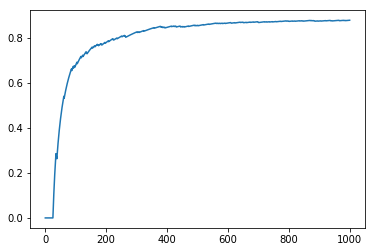

In [16]:
plt.plot(optRatio)

## Q value vs qstar

Q[k]代表所有采取行动k的reward的平均，而qstar[k]代表行动k的reward的数学期望。当$nStep\to\infty$时应该有$Q[k]\to q_*[k]$.

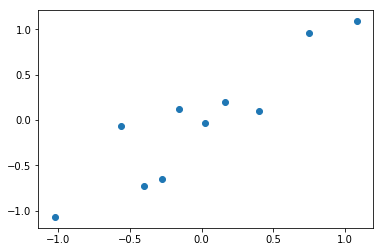

In [17]:
plt.scatter(qstar,Q)

## Number of actions vs qstar

aNum[k]代表所有采取action#k被选择的次数，而qstar[k]代表action#k的reward的数学期望。当$nStep\to\infty$时理论上来说应该有reward期望越高的行动被选择的次数越多。但是与$Q[k]\propto q_*[k]$不同，各action被选择的次数应该遵循马太效应，即最后应该集中在最高q值的action或最高的几个actions上
不过从实验结果来看，并不一定是q值最高的action被选择次数最高

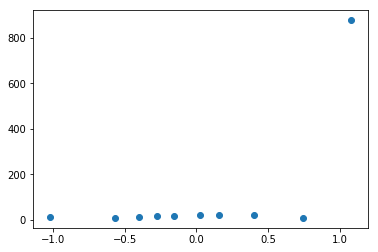

In [18]:
plt.scatter(qstar,aNum)

## Comparison between different epsilon
* 仿真控制参数
    * number of steps
    * number of run
    * K: The number of candidate actions    
* Input:
    * qstar[K]
    * epsilon: greedy factor $\epsilon$
* Output:
    * a[t]: action series for each step in one run
    * r[t]: reward series for each step in one run
    * Q[k]: reward sample average up to t-1 for action[k].
Note!!!: qstar randonmization should be put inside the outer loop to make each run representing a different bandit problem.

In [19]:
nStep = 1000
nRun  = 2000
#qstar   = np.random.randn(10) 

r_0p0   = np.zeros((nRun,nStep+1))
r_0p1   = np.zeros((nRun,nStep+1))
r_0p01  = np.zeros((nRun,nStep+1))
optRatio_0p0 = np.zeros((nRun,nStep+1))
optRatio_0p1 = np.zeros((nRun,nStep+1))
optRatio_0p01= np.zeros((nRun,nStep+1))

for run in range(nRun):
    print('.',end='')
    if run%100==99:        
        print('run = ',run+1)
    
    qstar   = np.random.randn(10) 
    a,aNum,r_0p0[run,:],Q,optRatio_0p0[run,:] = k_armed_bandit_one_run(qstar,epsilon=0,nStep=nStep)
    a,aNum,r_0p1[run,:],Q,optRatio_0p1[run,:] = k_armed_bandit_one_run(qstar,epsilon=0.1,nStep=nStep)
    a,aNum,r_0p01[run,:],Q,optRatio_0p01[run,:] = k_armed_bandit_one_run(qstar,epsilon=0.01,nStep=nStep)


....................................................................................................run =  100
....................................................................................................run =  200
....................................................................................................run =  300
....................................................................................................run =  400
....................................................................................................run =  500
....................................................................................................run =  600
....................................................................................................run =  700
....................................................................................................run =  800
....................................................................................................run =  900
.

## Average Reward

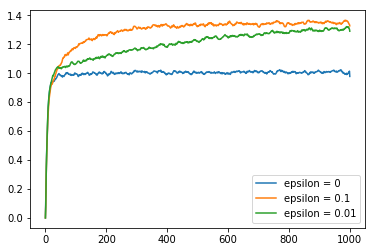

In [21]:
rEnsembleMean_0p0 = np.mean(r_0p0,axis=0)
rEnsembleMean_0p1 = np.mean(r_0p1,axis=0)
rEnsembleMean_0p01 = np.mean(r_0p01,axis=0)
#plt.plot(rEnsembleMean)
plt.plot(util.smooth(rEnsembleMean_0p0,11))
plt.plot(util.smooth(rEnsembleMean_0p1,11))
plt.plot(util.smooth(rEnsembleMean_0p01,11))
plt.legend(['epsilon = 0','epsilon = 0.1','epsilon = 0.01'])

## Optimal Action
Optimal Action是指对应于$q_*$中期望值最高的那个。In the above simulation, $q_*$ is re-initialized for each run. Hence, in simulation, the optimal action counting must be tracked in each run in a cumulative way.

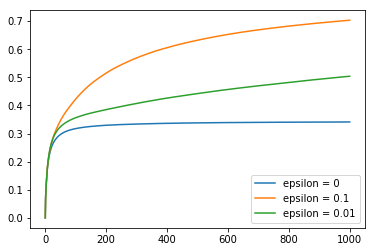

In [22]:
optRatioEnsembleMean_0p0 = np.mean(optRatio_0p0,axis=0)
optRatioEnsembleMean_0p1 = np.mean(optRatio_0p1,axis=0)
optRatioEnsembleMean_0p01 = np.mean(optRatio_0p01,axis=0)
#plt.plot(rEnsembleMean)
plt.plot(util.smooth(optRatioEnsembleMean_0p0,11))
plt.plot(util.smooth(optRatioEnsembleMean_0p1,11))
plt.plot(util.smooth(optRatioEnsembleMean_0p01,11))
plt.legend(['epsilon = 0','epsilon = 0.1','epsilon = 0.01'])

## Observation
上图结果与书中的Figure2.2基本是一致的(就相对关系以及变化趋势而言，具体的收敛值有一定差异)。
In case of epsilon=0, the convergence value=1.0, is this an inevitable result, for example, can be derived mathematically under the assumption?